In [1]:
%load_ext sql
%sql sqlite:///../src/tweets.db
%sql PRAGMA foreign_keys = ON;

Done.


[]

In [2]:
import requests
import json
import sqlite3
import dateutil
import pandas as pd
import numpy as np
db = sqlite3.connect('../src/tweets.db')

In [3]:
%%sql
select * from cryptos where date>='2018-02-23 14:20:00' and symbol='ETH' order by date desc limit 0,5

Done.


date,symbol,price,volume,market_cap
2018-02-28 20:05:00,ETH,871.58862551,216820.15161497,188977977.92985
2018-02-28 20:00:00,ETH,868.24922747,215750.17953381,187324926.70598
2018-02-28 19:55:00,ETH,867.44097638,215283.49806942,186745727.76425
2018-02-28 19:50:00,ETH,867.03549857,215486.80466862,186834709.12159
2018-02-28 19:45:00,ETH,866.79386563,216150.605191,187358018.63274


In [4]:
cur = db.cursor()
cur.execute("SELECT * FROM cryptos order by date desc")

rows = cur.fetchall()

df = pd.DataFrame(columns=['date', 'symbol', 'price', 'volume', 'market_cap'], data=rows)
df.date = pd.to_datetime(df.date)
df.head()

,date,symbol,price,volume,market_cap
0,2018-02-28 20:05:00,XRP,0.909910,4.598080e+07,4.183841e+07
1,2018-02-28 20:05:00,LTC,209.383819,7.366022e+05,1.542326e+08
2,2018-02-28 20:05:00,ETH,871.588626,2.168202e+05,1.889780e+08
3,2018-02-28 20:05:00,ETC,33.798853,8.765664e+05,2.962694e+07
4,2018-02-28 20:05:00,BTC,10602.050667,9.295476e+04,9.855111e+08


In [58]:
# NOT NEEDED, since we're using Grouper
# create hour column
def extract_hour(row):
    date = dateutil.parser.parse(row.date)
    return int('{year}{month}{day}{hour}'.format(
        year = date.year,
        month = str(date.month).zfill(2),
        day = str(date.day).zfill(2),
        hour = str(date.hour).zfill(2)
    ))
df['hour'] = df.apply(extract_hour, axis=1)

In [23]:
def price_open(col):
    return col.iloc[0]
def price_close(col):
    return col.iloc[col.shape[0]-1]

adf = df.groupby([pd.Grouper(key='date', freq='1h'), 'symbol'])
adf = adf.agg({
    'price': [np.mean, np.min, np.max, price_open, price_close],
    'volume': np.mean,
    'market_cap': np.mean
})
# change column names
adf.columns = ['price_mean', 'price_min', 'price_max', 'price_open', 'price_close', 'volume', 'market_cap']
adf = adf.sort_index(ascending=False)

# add id column and change hour from index to generic column
# adf['id'] = np.arange(adf.shape[0])
# adf['hour'] = adf.index
# adf.set_index('id', inplace=True)

adf.head(10)

price_mean     price_min     price_max  \
date                symbol                                             
2018-02-28 20:00:00 XRP         0.909154      0.908397      0.909910   
                    LTC       208.760243    208.136667    209.383819   
                    ETH       869.918926    868.249227    871.588626   
                    ETC        33.717096     33.635339     33.798853   
                    BTC     10582.707543  10563.364419  10602.050667   
                    BCH      1227.347550   1225.411128   1229.283972   
2018-02-28 19:00:00 XRP         0.907313      0.906086      0.908247   
                    LTC       207.490983    207.059111    207.891046   
                    ETH       866.595748    865.741744    867.440976   
                    ETC        33.511742     33.400599     33.582192   

                              price_open   price_close        volume  \
date                symbol                                             
2018-02-28 20:00:00 XRP         0.909910      0.908397  4.602686e+07   
                    LTC       209.383819    208.136667  7.347768e+05   
                    ETH       871.588626    868.249227  2.162852e+05   
                    ETC        33.798853     33.635339  8.758231e+05   
                    BTC     10602.050667  10563.364419  9.273544e+04   
                    BCH      1229.283972   1225.411128  4.119494e+04   
2018-02-28 19:00:00 XRP         0.908247      0.907636  4.695495e+07   
                    LTC       207.476735    207.436504  7.346627e+05   
                    ETH       867.440976    865.741744  2.178621e+05   
                    ETC        33.582192     33.462736  9.224671e+05   

                              market_cap  
date                symbol                
2018-02-28 20:00:00 XRP     4.184545e+07  
                    LTC     1.533933e+08  
                    ETH     1.881515e+08  
                    ETC     2.953027e+07  
                    BTC     9.813963e+08  
                    BCH     5.056063e+07  
2018-02-28 19:00:00 XRP     4.260273e+07  
                    LTC     1.524360e+08  
                    ETH     1.887979e+08  
                    ETC     3.091181e+07

In [7]:
# UNUSED FOR NOW
# compare current row with current rolling window
def temp(row, window):
    # check if lowest bound of the window exists
    low_bound = row.name+window
    if (low_bound-1 not in adf.index.values):
        return np.nan
    # find df subset of current window lenght
    subset = adf.iloc[row.name:low_bound]
    # open price corresponds to the last value of the subset
    price_open = subset.iloc[::-1].iloc[0].price_open
    price_close = row.price_close
    #print(row.hour, price_open, price_close)
    return (price_close-price_open)/price_open

window = 1
adf['{}hr_change'.format(window)] = adf.apply(lambda r: temp(r, window), axis=1)
adf.head()

,price_mean,price_min,price_max,price_open,price_close,volume,market_cap,hour,1hr_change
id,,,,,,,,,
0,2153.893419,0.908397,10602.050667,0.908397,1229.283972,7.997945e+06,2.408129e+08,2018-02-28 20:00:00,1352.245346
1,2141.759203,0.906086,10540.475798,0.907636,1223.505002,8.160729e+06,2.409507e+08,2018-02-28 19:00:00,1347.012758
2,2139.650209,0.903347,10551.468234,0.903347,1218.983122,8.234268e+06,2.415915e+08,2018-02-28 18:00:00,1348.408127
3,2132.140714,0.900424,10502.906008,0.900424,1214.989305,8.235872e+06,2.396381e+08,2018-02-28 17:00:00,1348.352422
4,2135.467500,0.900242,10538.235923,0.905511,1212.566270,8.224579e+06,2.402830e+08,2018-02-28 16:00:00,1338.095518


In [158]:
%matplotlib inline

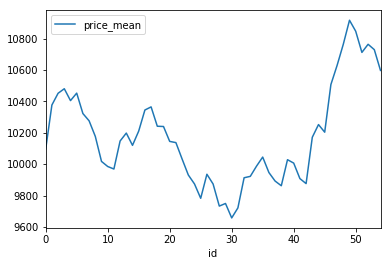

In [160]:
adf.loc[:, ['price_mean']].plot()

In [ ]:
db.close()